# CRAFT on RoBERTa Classifieur (NLP)

# 0 - Summary

Context:  
* build an in-house text classifier quotes from e-commerce reviews of beauty products (22 marketing topics).
* Current model : a fine-tuned RoBERTa-large reaches ≈ 80 % global accuracy but per-class F1 ranges from 40 % to 95 %.  
* Major pain-point : strong overlap between some categories (see confusion matrix)

Methode:  
* Use craft on two overlaped classes et two well-separated classes and compare results.

CRAFT adapted to text:  
* g(text) → last-hidden-state pooling of RoBERTa (1024 d).
* Custom batching + chunking to fit Sobol on quotes.
* Token-level heat-map: projection |h|·W × sign(h) + HTML coloring.

Key result but limitation:
* We can assert that the overlap of topics is due to an overlap of some concepts. However, we are not able to translate concepts into words and links between words.

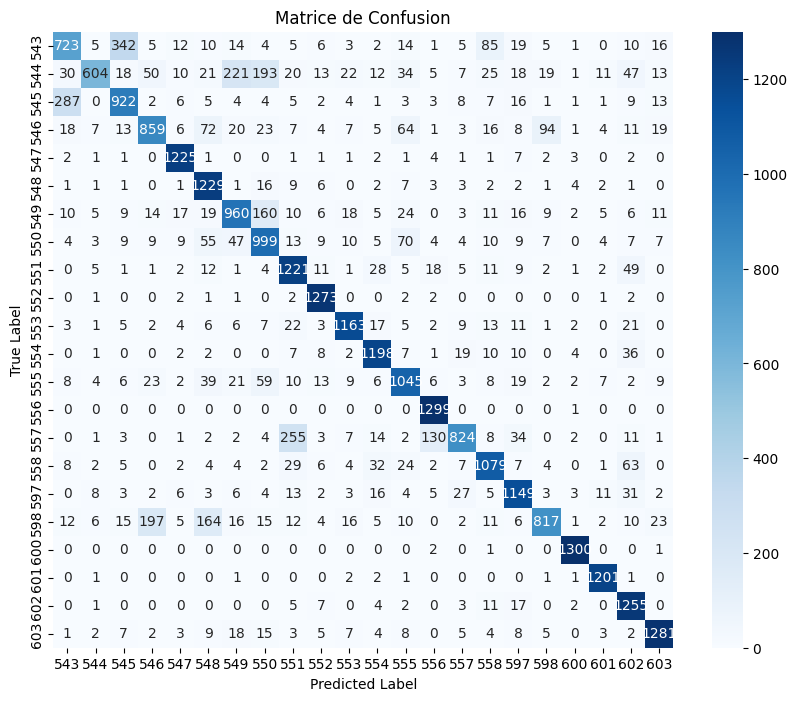

## 1 - Init : Craft (fork), RoBERTa, data

**Why this fork?**  
The original CRAFT implementation targets image explainability (patch extraction, heavy GPU batches).  
For large-scale text classification we faced two blockers:  

*  Manage texts sequences instead of images
*  Batch et chunk processes to preserve cpu ram  



In [ ]:
import sys
!git clone https://github.com/lolomasterIA/Craft.git
sys.path.append("/content/Craft")

Cloning into 'Craft'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 195 (delta 107), reused 9 (delta 4), pack-reused 38 (from 1)
Receiving objects: 100% (195/195), 45.54 MiB | 28.65 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [ ]:
# imports and constants
import pandas as pd
import numpy as np
import craft.craft_torch
from craft.craft_torch import Craft, torch_to_numpy
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import PeftModel, PeftConfig
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import HTML, display
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
google_path = "Master IA/BGDIA706/Datasamples/"


In [ ]:
# Load model
# it is a Roberta trained for l'Oreal classifieur
model_path = "english_roberta"
tokenizerBob = AutoTokenizer.from_pretrained(model_path)
adapter_config = PeftConfig.from_pretrained(model_path)
base_model = AutoModelForSequenceClassification.from_pretrained("roberta-large", num_labels=22)
modelBob = PeftModel.from_pretrained(base_model, model_path)
modelBob.eval().cuda()

In [ ]:
# Get the last hidden layer + Relu
def g(texts):
    inputs = tokenizerBob(texts, padding=True, truncation=True, return_tensors="pt").to(modelBob.device)

    with torch.no_grad():
        outputs = modelBob.base_model(**inputs, output_hidden_states=True, return_dict=True)
        hidden_states = outputs.hidden_states[-1]
        pooled = hidden_states.mean(dim=1)
        return F.relu(pooled) #here, we use ReLu to catch only positive activations, mandatory for MNF

dense = modelBob.classifier.dense
dropout = modelBob.classifier.dropout
out_proj = modelBob.classifier.out_proj

def h(latent):
    with torch.no_grad():
        x = dropout(latent)
        x = dense(x)
        x = torch.tanh(x)
        x = dropout(x)
        x = out_proj(x)
        return x


In [ ]:
# chargement des données
def mount_path_from_google(google_path, device):
    from google.colab import drive
    drive.mount('/content/gdrive')
    data_path = '/content/gdrive/MyDrive/' + google_path
    model_path = "/content/gdrive/MyDrive/"
    return data_path, model_path

def get_labels(file_content: str):
    df = pd.read_csv(file_content)

    label_mapping = {old_label: idx for idx, old_label in enumerate(sorted(set(df["topic_id"])))}
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}

    return label_mapping, reverse_label_mapping

def filter_reviews_two_classes_separated(file_content: str, language: str = "", topic_x=123, topic_y=456, n=100):
    df = pd.read_csv(file_content)

    if language:
        df = df[df['language'] == language]

    df = df[df["topic_id"].isin([topic_x, topic_y])]

    # Échantillonner n exemples par classe
    df_x = df[df["topic_id"] == topic_x].sample(n=n, random_state=42).reset_index(drop=True)
    df_y = df[df["topic_id"] == topic_y].sample(n=n, random_state=42).reset_index(drop=True)

    return df_x, df_y,



In [ ]:
if str(device) == "cuda":
    datapath, modelpath = mount_path_from_google(google_path, device)
    samplesfile = str(datapath) + "final_processed_data.csv"

label_mapping, reverse_label_mapping = get_labels(samplesfile)

Mounted at /content/gdrive


Here, the format of the data, quote_text_clean is our final processed input (sequences to classify):    

| language | country_id | topic_id | quote_id     | quote_text                                                                   | review_text                                                                                                                                                                                                                                  | keyword     | quote_text_clean                              |
|----------|------------|----------|--------------|-------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------|------------------------------------------------|
| en       | 2          | 543      | 35601302002  | but bottle of chemical gases. No fragrance present.                          | Waste of money. Don't but it even the price drops below 100. Total waste smell like chemical. Not a deo but bottle of chemical gases. No fragrance present. Three of them smell exactly same i.e. mix of alcohol and other gases.         | presentation | bottle chemical gasesno fragrance present      |
| en       | 2          | 543      | 17694971002  | Im having some designer perfumes and comparing with some fresh perfumes...   | This beardo products smells really good and its longevity is also nice. We can wear this perfume to office purpose also. Considering its cost, must buy.                                             | design      | designer perfume compare fresh perfume one good |


## 2 - Apply CRAFT

In [ ]:
# fonction de calcul Sobol
def compute_sobol(texts_all, labels_all, nb_concept=20, nb_design=8, batch_size=256):
    craft = Craft(
        input_to_latent=g,
        latent_to_logit=h,
        number_of_concepts=nb_concept,
        batch_size=batch_size,
        device="cuda" if torch.cuda.is_available() else "cpu",
    )

    patches, U, W = craft.fit(texts_all)     #  patches = None for text sequences

    sobol_y = craft.estimate_importance_vector(texts_all, class_id=1, nb_design=nb_design)
    sobol_x = craft.estimate_importance_vector(texts_all, class_id=0, nb_design=nb_design)

    delta = U[labels_all == 1].mean(0) - U[labels_all == 0].mean(0)
    signed_imp_y = sobol_y * np.sign(delta)
    signed_imp_x = sobol_x * -np.sign(delta)

    return sobol_y, sobol_x, signed_imp_y, signed_imp_x, U, W, craft


def display_sobol(sobol_y, sobol_x, signed_imp_y, signed_imp_x, U, labels_all):
    top10_y = np.argsort(-sobol_y)[:10]
    top10_x = np.argsort(-sobol_x)[:10]

    labels_all = np.array(labels_all)
    U_0 = U[labels_all == 0]
    U_1 = U[labels_all == 1]

    if len(U_0) == 0 or len(U_1) == 0:
        raise ValueError("no example for at least one topic")

    delta = U_1.mean(0) - U_0.mean(0)

    # Affichage classe 1 (topic_y)
    print("=== Topic Y (classe 1) ===")
    for k in top10_y:
        delta_k = delta[k]
        if hasattr(delta_k, "item"):
            delta_k = delta_k.item()
        print(f"id {k:2d} | Sobol={float(sobol_y[k]):.4f} | Δ={delta_k:+.3f}")

    print("=== Topic X (classe 0) ===")
    for k in top10_x:
        delta_k = delta[k]
        if hasattr(delta_k, "item"):
            delta_k = delta_k.item()
        print(f"id {k:2d} | Sobol={float(sobol_x[k]):.4f} | Δ={delta_k:+.3f}")

def display_texts_for_concept(texts, k, U, topn=5):
    """
    Affiche les top-n phrases les plus activées pour le concept k
    """
    activations = U[:, k]
    top_ids = np.argsort(-activations)[:topn]

    print(f"\n Concept {k} — top {topn} phrases :")
    for i in top_ids:
        print(f"  [{activations[i]:.3f}] {texts[i]}")

def plot_delta_sobol(delta_vals,
                     sobol_vals,
                     ids=None,
                     delta_thresh=None,
                     sobol_thresh=None,
                     ax=None):
    """
    Scatter |Δ| vs Sobol avec code couleur sur le signe de Δ.
    """
    delta_vals  = np.asarray(delta_vals).ravel()
    sobol_vals  = np.asarray(sobol_vals).ravel()
    ids         = ids if ids is not None else range(len(delta_vals))

    abs_delta   = np.abs(delta_vals)
    sign_delta  = np.sign(delta_vals)          # -1, 0, +1

    if delta_thresh is None:
        delta_thresh = 0.5 * np.percentile(abs_delta, 90)
    if sobol_thresh is None:
        sobol_thresh = 0.5 * np.percentile(sobol_vals, 90)

    cmap = ListedColormap(["tab:blue", "tab:orange"])

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    ax.scatter(sobol_vals,
               abs_delta,
               c=(sign_delta > 0).astype(int),  # 0 ou 1
               cmap=cmap)

    ax.axvline(sobol_thresh, linestyle="--", color="grey")
    ax.axhline(delta_thresh, linestyle="--", color="grey")

    for x, y, label in zip(sobol_vals, abs_delta, ids):
        ax.text(x, y, str(label), fontsize=8,
                ha="right", va="bottom")

    ax.set_xlabel("Sobol (influence)")
    ax.set_ylabel("|Δ| (force d’asymétrie)")
    ax.set_title("Influence vs Asymétrie par concept\n(couleur = classe favorisée)")
    ax.grid(True, linestyle=":")

    handles = [plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=cmap(0), markersize=8, label="Δ < 0 (classe 0)"),
               plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=cmap(1), markersize=8, label="Δ > 0 (classe 1)")]
    ax.legend(handles=handles, loc="upper right")

    return ax

def html_highlight(tokens, scores, threshold=0.05):
    """
    Colorise les tokens en rouge (positif) ou bleu (négatif).
    """
    scores = np.asarray(scores)
    pos_max = scores[scores > 0].max(initial=1e-6)
    neg_max = (-scores[scores < 0]).max(initial=1e-6)

    html_tokens = []
    for tok, s in zip(tokens, scores):
        tok_clean = tok.replace("Ġ", "")
        if abs(s) < threshold:
            html_tokens.append(tok_clean)
            continue

        if s > 0:
            c = cm.Reds(s / pos_max)
            text_color = "#ffffff"  # blanc sur rouge
        else:
            c = cm.Blues((-s) / neg_max)
            text_color = "#ffffff"  # blanc sur bleu

        bg_hex = "#{:02x}{:02x}{:02x}".format(
            int(c[0]*255), int(c[1]*255), int(c[2]*255))

        style = (
            f"background:{bg_hex};"
            f"color:{text_color};"
            "padding:2px 4px;"
            "border-radius:4px;"
            "margin:1px;"
        )
        html_tokens.append(f"<span style='{style}'>{tok_clean}</span>")

    return " ".join(html_tokens)



In [ ]:
# number samples by classes
n = 512

# see confusion matrix
# 2 classes with overlap
topic_x = 545
topic_y = 543
df_x, df_y = filter_reviews_two_classes_separated(
    samplesfile, language="en", topic_x=topic_x, topic_y=topic_y, n=n
)
texts_all_over = df_x["quote_text_clean"].tolist() + df_y["quote_text_clean"].tolist()
labels_all_over = [0] * len(df_x) + [1] * len(df_y)

# 2 classes well separated
topic_x = 552
topic_y = 600
df_x, df_y = filter_reviews_two_classes_separated(
    samplesfile, language="en", topic_x=topic_x, topic_y=topic_y, n=n
)
texts_all_sep = df_x["quote_text_clean"].tolist() + df_y["quote_text_clean"].tolist()
labels_all_sep = [0] * len(df_x) + [1] * len(df_y)


We train two craft models, one for overlaped topic (_over) and another one for separated topic (_sep)

In [ ]:
sobol_y_over, sobol_x_over, signed_imp_y_over, signed_imp_x_over, U_over, W_over, craft_over = compute_sobol(texts_all_over, labels_all_over, nb_concept=20, nb_design=32, batch_size=256)
sobol_y_sep, sobol_x_sep, signed_imp_y_sep, signed_imp_x_sep, U_sep, W_sep, craft_sep = compute_sobol(texts_all_sep, labels_all_sep, nb_concept=20, nb_design=32, batch_size=256)

<ipython-input-7-3537085678>:16: RuntimeWarning: Mean of empty slice.
  delta = U[labels_all == 1].mean(0) - U[labels_all == 0].mean(0)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
<ipython-input-7-3537085678>:16: RuntimeWarning: Mean of empty slice.
  delta = U[labels_all == 1].mean(0) - U[labels_all == 0].mean(0)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


### 2.1 - Craft results explaination

**Metrics:**  
We use two metrics to evaluate the overlaping between two topics:  
*   Delta: “Is the concept k more present in one class than in the other?"  
Average difference in concept activation between classes
*   Sobol indice: “If I vary the concept k, does the algorithm really change its prediction?”  
Sensitivity (explained variance) of the model output to the concept

**interpretation:**  
\begin{array}{|l|c|c|l|}
\hline
\textbf{Situation} & \boldsymbol{\lvert\Delta_k\rvert} & \boldsymbol{\text{Sobol}_k} & \textbf{Lecture pratique} \\
\hline
\text{specific concept for a classe} & > \text{threshold} & \text{high} & \text{Powerful discriminating signal} \\
\text{Shared but used concept}    & \approx 0      & \text{high} & \text{overlap (be careful, non-linear lever)} \\
\text{discriminating concept but underutilized} & > \text{threshold} & \text{low} & \text{Underutilized information} \\
\text{Anecdotal concept (noise)}     & \approx 0      & \text{low} & \text{Negligible impact} \\
\hline
\end{array}

### 2.2 - Results for overlap

In [ ]:
print("Metrics for overlap topics: ")
display_sobol(sobol_y_over, sobol_x_over, signed_imp_y_over, signed_imp_x_over, U_over, labels_all_over)


Metrics for overlap topics: 
=== Topic Y (classe 1) ===
id  9 | Sobol=1.7970 | Δ=-0.000
id  1 | Sobol=1.7729 | Δ=+0.050
id 14 | Sobol=1.7199 | Δ=-0.055
id 12 | Sobol=1.6256 | Δ=-0.006
id 17 | Sobol=1.5195 | Δ=-0.033
id  6 | Sobol=1.4953 | Δ=-0.008
id  5 | Sobol=1.4435 | Δ=+0.017
id  4 | Sobol=1.4412 | Δ=-0.026
id 10 | Sobol=1.4384 | Δ=-0.005
id 15 | Sobol=1.4229 | Δ=-0.010
=== Topic X (classe 0) ===
id 14 | Sobol=1.5597 | Δ=-0.055
id  9 | Sobol=1.3895 | Δ=-0.000
id  4 | Sobol=1.3413 | Δ=-0.026
id 12 | Sobol=1.3235 | Δ=-0.006
id 17 | Sobol=1.2750 | Δ=-0.033
id 19 | Sobol=1.2715 | Δ=+0.123
id  1 | Sobol=1.2526 | Δ=+0.050
id  6 | Sobol=1.2113 | Δ=-0.008
id 10 | Sobol=1.1524 | Δ=-0.005
id  8 | Sobol=1.1296 | Δ=+0.001


For better understanding, represent the metrics according to the interpretation method.

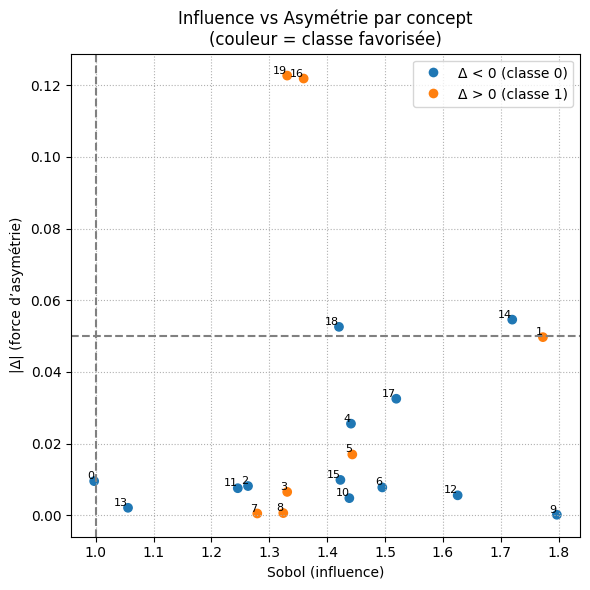

In [ ]:
labels_arr_over = np.asarray(labels_all_over)
delta_vals = (U_over[labels_arr_over == 1].mean(axis=0) -
              U_over[labels_arr_over == 0].mean(axis=0))

sobol_vals = sobol_y_over

delta_vals = np.asarray(delta_vals).ravel()
sobol_vals = np.asarray(sobol_vals).ravel()

delta_thresh  = 0.5 * np.percentile(np.abs(delta_vals), 90)
sobol_thresh  = 0.5 * np.percentile(sobol_vals, 90)

plot_delta_sobol(delta_vals,
                      sobol_vals,
                      ids=list(range(len(delta_vals))),
                      delta_thresh=0.05,
                      sobol_thresh=1.0)
plt.tight_layout()
plt.show()


Only concepts 16 and 19 have a delta > 0.6 and ~1.2, but with a Sobol score between 1.3 and 1.4. Concept 9 has weight but does not help distinguish the two classes (delta ~ 0).  
Overall, the Sobol indices and deltas are low.
This explains the classifier's difficulty in distinguishing the two classes.

We will see below that the same exercise on the two well-separated classes produces the opposite result.

In [ ]:
print("textes fréquents par concept classe overlap")
for k in [9, 1, 14, 16, 19]:
    display_texts_for_concept(texts_all_over, k, U_over)


textes fréquents par concept classe overlap

 Concept 9 — top 5 phrases :
  [0.018] first time not happy kay beauty waste money particular product
  [0.018] use mascara 40 year not know keep try other waste money mascara claim give long beautiful lash
  [0.018] product expensive enough not want waste
  [0.016] many time wish beautiful perfume bottle not go waste not
  [0.016] smell bad liquidly   not form foam expensive side can not anything waste money

 Concept 1 — top 5 phrases :
  [0.756] make face even ugly
  [0.749] would not blend would fade really ugly way
  [0.731] also make nail look thick ugly take forever dry
  [0.730] try work definitely end ugly look
  [0.730] not flake leave ugly smudge

 Concept 14 — top 5 phrases :
  [0.895] price high end
  [0.891] never think high end powder worth
  [0.866] try several product high low end claim contour
  [0.864] always try new foundation high low end
  [0.860] scent remind high end salonspa linger hair dry

 Concept 16 — top 5 phras

In [ ]:
texts = random.sample(texts_all_over, k=10)

concept_id = 9

for i, t in enumerate(texts, 1):
    with torch.no_grad():
        batch   = tokenizerBob(t, return_tensors="pt").to(modelBob.device)
        logits  = modelBob(**batch).logits             # (1, nb_topics)
        pred_id = logits.argmax(dim=-1).item()         # entier
        pred_lab= reverse_label_mapping.get(pred_id, f"id_{pred_id}")

    toks, scs = craft_over.token_heatmap(
        t,
        concept_id=concept_id,
        tokenizer=tokenizerBob,
        encoder=modelBob.base_model
    )
    html = html_highlight(toks, scs, threshold=0.05)

    display(HTML(
        f"<b>Phrase&nbsp;{i} — prediction:</b> "
        f"<span style='color:#006'>{pred_lab}</span><br>"
        f"{html}"
    ))

All tokens are in red because Token scores = |h|.W x sign(h) and most negative words share a common sign.
[texte du lien](https://)
Δ ≈ 0 → no clear contrast between classes; internal contrast is weak.

In [ ]:
texts = random.sample(texts_all_over, k=10)

concept_id = 16

for i, t in enumerate(texts, 1):
    with torch.no_grad():
        batch   = tokenizerBob(t, return_tensors="pt").to(modelBob.device)
        logits  = modelBob(**batch).logits             # (1, nb_topics)
        pred_id = logits.argmax(dim=-1).item()         # entier
        pred_lab= reverse_label_mapping.get(pred_id, f"id_{pred_id}")

    toks, scs = craft_over.token_heatmap(
        t,
        concept_id=concept_id,
        tokenizer=tokenizerBob,
        encoder=modelBob.base_model
    )
    html = html_highlight(toks, scs, threshold=0.05)

    display(HTML(
        f"<b>Phrase&nbsp;{i} — prediction:</b> "
        f"<span style='color:#006'>{pred_lab}</span><br>"
        f"{html}"
    ))

Even if concept 16 favors class 543. This is not enough to classify well (be careful, as we say below, the model being broad and complex, the analysis of a single concept cannot explain, even 20 seem insufficient, RoBERTa can find very weak correlations but useful for classification)

### 2.3 Results for well separated


In [ ]:
print("Metrics for separated topics : ")
display_sobol(sobol_y_sep, sobol_x_sep, signed_imp_y_sep, signed_imp_x_sep, U_sep, labels_all_sep)

Metrics for separated topics : 
=== Topic Y (classe 1) ===
id 14 | Sobol=2.0852 | Δ=+0.142
id 12 | Sobol=1.8550 | Δ=-0.109
id  4 | Sobol=1.8356 | Δ=-0.016
id 15 | Sobol=1.6593 | Δ=-0.098
id  2 | Sobol=1.5549 | Δ=+0.063
id  9 | Sobol=1.5506 | Δ=-0.012
id  6 | Sobol=1.5379 | Δ=-0.011
id 17 | Sobol=1.4990 | Δ=+0.163
id 10 | Sobol=1.4523 | Δ=+0.010
id  0 | Sobol=1.4408 | Δ=+0.026
=== Topic X (classe 0) ===
id  4 | Sobol=2.1412 | Δ=-0.016
id 15 | Sobol=2.0841 | Δ=-0.098
id 13 | Sobol=1.8968 | Δ=+0.068
id  0 | Sobol=1.8369 | Δ=+0.026
id  8 | Sobol=1.8103 | Δ=+0.036
id 17 | Sobol=1.6613 | Δ=+0.163
id 19 | Sobol=1.6558 | Δ=+0.009
id 18 | Sobol=1.5958 | Δ=-0.245
id  6 | Sobol=1.5877 | Δ=-0.011
id  9 | Sobol=1.5072 | Δ=-0.012


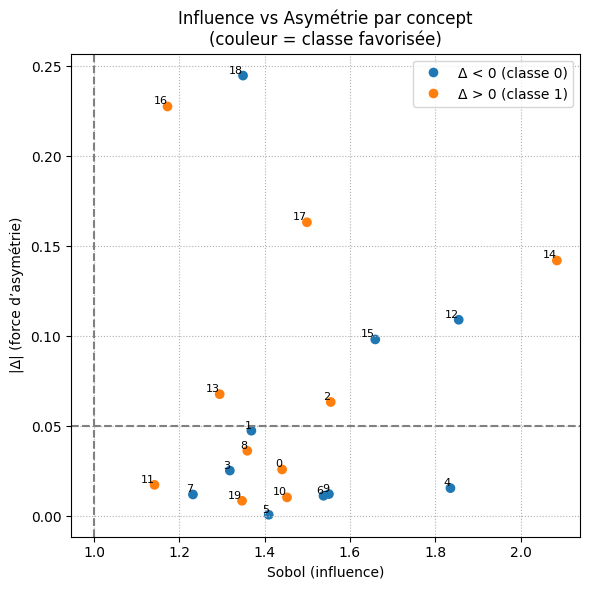

In [ ]:
labels_arr_sep = np.asarray(labels_all_sep)
delta_vals = (U_sep[labels_arr_sep == 1].mean(axis=0) -
              U_sep[labels_arr_sep == 0].mean(axis=0))

sobol_vals = sobol_y_sep

delta_vals = np.asarray(delta_vals).ravel()
sobol_vals = np.asarray(sobol_vals).ravel()

plot_delta_sobol(delta_vals,
                      sobol_vals,
                      ids=list(range(len(delta_vals))),
                      delta_thresh=0.05,
                      sobol_thresh=1.0)
plt.tight_layout()
plt.show()

Let's recall the results for overlapping classes: max 1.2 in delta and sobol < 1.8.  

Here, the values ​​are much more differentiated. Indeed, concepts 16 and 18 alone allow the prediction to be tilted from one class to the other (delta > 20 and sobol between 1.1 and 1.4). We also see concept 14: sobol > 2 and delta ~ 1.5.

In [ ]:
print("textes fréquents par concept classe séparée")
for k in [16, 18, 14]:
    display_texts_for_concept(texts_all_over, k, U_sep)


textes fréquents par concept classe séparée

 Concept 16 — top 5 phrases :
  [2.447] glide beautifully love wand wand fluffy bristle get everywhere eye wand short bristle fantastic
  [2.265] engage amber hue premium long last perfume man stand liberation   new identity provocation seduction fruity ambery note
  [2.230] remarkable formula leave hair feel rejuvenated look stunningly beautiful
  [1.741] not expensive great quality
  [1.726] coverage beautiful build

 Concept 18 — top 5 phrases :
  [2.972] love hydration feel luxurious
  [2.799] love cleanser pity expensive buy often
  [2.775] great smell cheap price cam well packing long last
  [2.692] use spend much hair spray think work well fancy brand
  [2.622] try lot different kind drugstore prestige luxury

 Concept 14 — top 5 phrases :
  [0.811] several shade great staying power beautiful shade
  [0.808] luxurious application shimmer even eye catch show stopper
  [0.806] jar not glass state presentation
  [0.801] dryer stop work t

In [ ]:
texts = random.sample(texts_all_sep, k=10)

concept_id = 18

for i, t in enumerate(texts, 1):
    with torch.no_grad():
        batch   = tokenizerBob(t, return_tensors="pt").to(modelBob.device)
        logits  = modelBob(**batch).logits             # (1, nb_topics)
        pred_id = logits.argmax(dim=-1).item()         # entier
        pred_lab= reverse_label_mapping.get(pred_id, f"id_{pred_id}")

    toks, scs = craft_sep.token_heatmap(
        t,
        concept_id=concept_id,
        tokenizer=tokenizerBob,
        encoder=modelBob.base_model
    )
    html = html_highlight(toks, scs, threshold=0.05)

    display(HTML(
        f"<b>Phrase&nbsp;{i} — prediction:</b> "
        f"<span style='color:#006'>{pred_lab}</span><br>"
        f"{html}"
    ))

We can clearly see that concept 18 is associated with class 552. It is very little activated on the words of the quotes of class 600. Big color contrast compared to the analysis on the overlapping topics.

In [ ]:
texts = random.sample(texts_all_sep, k=10)

concept_id = 16

for i, t in enumerate(texts, 1):
    with torch.no_grad():
        batch   = tokenizerBob(t, return_tensors="pt").to(modelBob.device)
        logits  = modelBob(**batch).logits             # (1, nb_topics)
        pred_id = logits.argmax(dim=-1).item()         # entier
        pred_lab= reverse_label_mapping.get(pred_id, f"id_{pred_id}")

    toks, scs = craft_sep.token_heatmap(
        t,
        concept_id=concept_id,
        tokenizer=tokenizerBob,
        encoder=modelBob.base_model
    )
    html = html_highlight(toks, scs, threshold=0.05)

    display(HTML(
        f"<b>Phrase&nbsp;{i} — prediction:</b> "
        f"<span style='color:#006'>{pred_lab}</span><br>"
        f"{html}"
    ))

Conversely and as expected, concept 16 is associated with class 600

## 3 - Limitations

**Concept limitations**:  

CRAFT concepts are latent vectors; they capture co-activations of tokens but do not preserve order or syntax. With only K = 20 concepts and without hierarchy (no recursive layer-by-layer extraction), we necessarily undersample the richness of a RoBERTa encoding (D = 1024): several linguistic phenomena are then mixed in the same concept.

**ReLu limitations**:

We applied a ReLU to make the activations strictly positive in order to remain compatible with the NMF. This masks the negative contributions (tokens that lower the logit). The gradients of the tanh head of the classifier, however, exploit these values ​​< 0; we therefore lose some of the decision nuance.  

**MNF limitations**:

La NMF de scikit-learn (multiplicative updates) n’est pas différentiable ; nous ne pouvons donc pas rétro-propager ∂U/∂A et obtenir des heat-maps locales façon papier CRAFT. Nous restons sur une explication globale (Sobol & Δ), ce qui est déjà utile mais moins fin que l’approche implicite-diff de la version JAX/Jaxopt décrite dans l’article.

**Concepts limitations**:  

A concept cannot yet be exactly understood by a human. It will be hard to converted concept into true word associations but we would be able to approximate it.  

And could we inject manual bias in the model after discovery (without impact on other classes...)?